# RNN for Time Series Prediction

This is a time series prediction task. You are given a dataset which reports on the weather and the level of pollution each hour for five years, and asked to train Recurrent Neural Networks (RNNs) to predict the hourly pollution level.

In [22]:
import numpy as np 
import pandas as pd 
import math
from datetime import datetime
import matplotlib.pyplot as plt # visualizing data
import seaborn as sns 
from collections import Counter
%matplotlib inline

In [23]:
# write your code here


'''
###############################################################################################################

NOTE: Please note that some comments were added after running, so they do not appear on the results section.
Comments are all in the code section.


################################################################################################################
'''


pollution = pd.read_csv('pollution.csv')
print(pollution.shape)

pollution.head()

(43824, 13)


,No,year,month,day,hour,pm2.5,Dew,Temperature,Pressure,Wind_Direction,Wind_Speed,Snow,Rain
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


a) Load the data from the file. Perform necessary pre-processing (e.g., missing value replacement, uninformative attribute removal, etc.) and visualise the values of various attributes over the five-year period.

2067 missing values BEFORE
0 missing values AFTER


(<seaborn.axisgrid.PairGrid at 0x7f52f61a7a20>,
 <seaborn.axisgrid.FacetGrid at 0x7f52cc77cf28>)

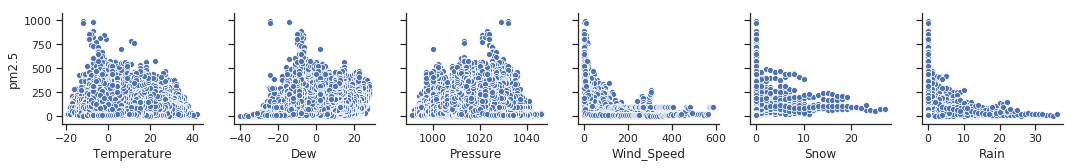

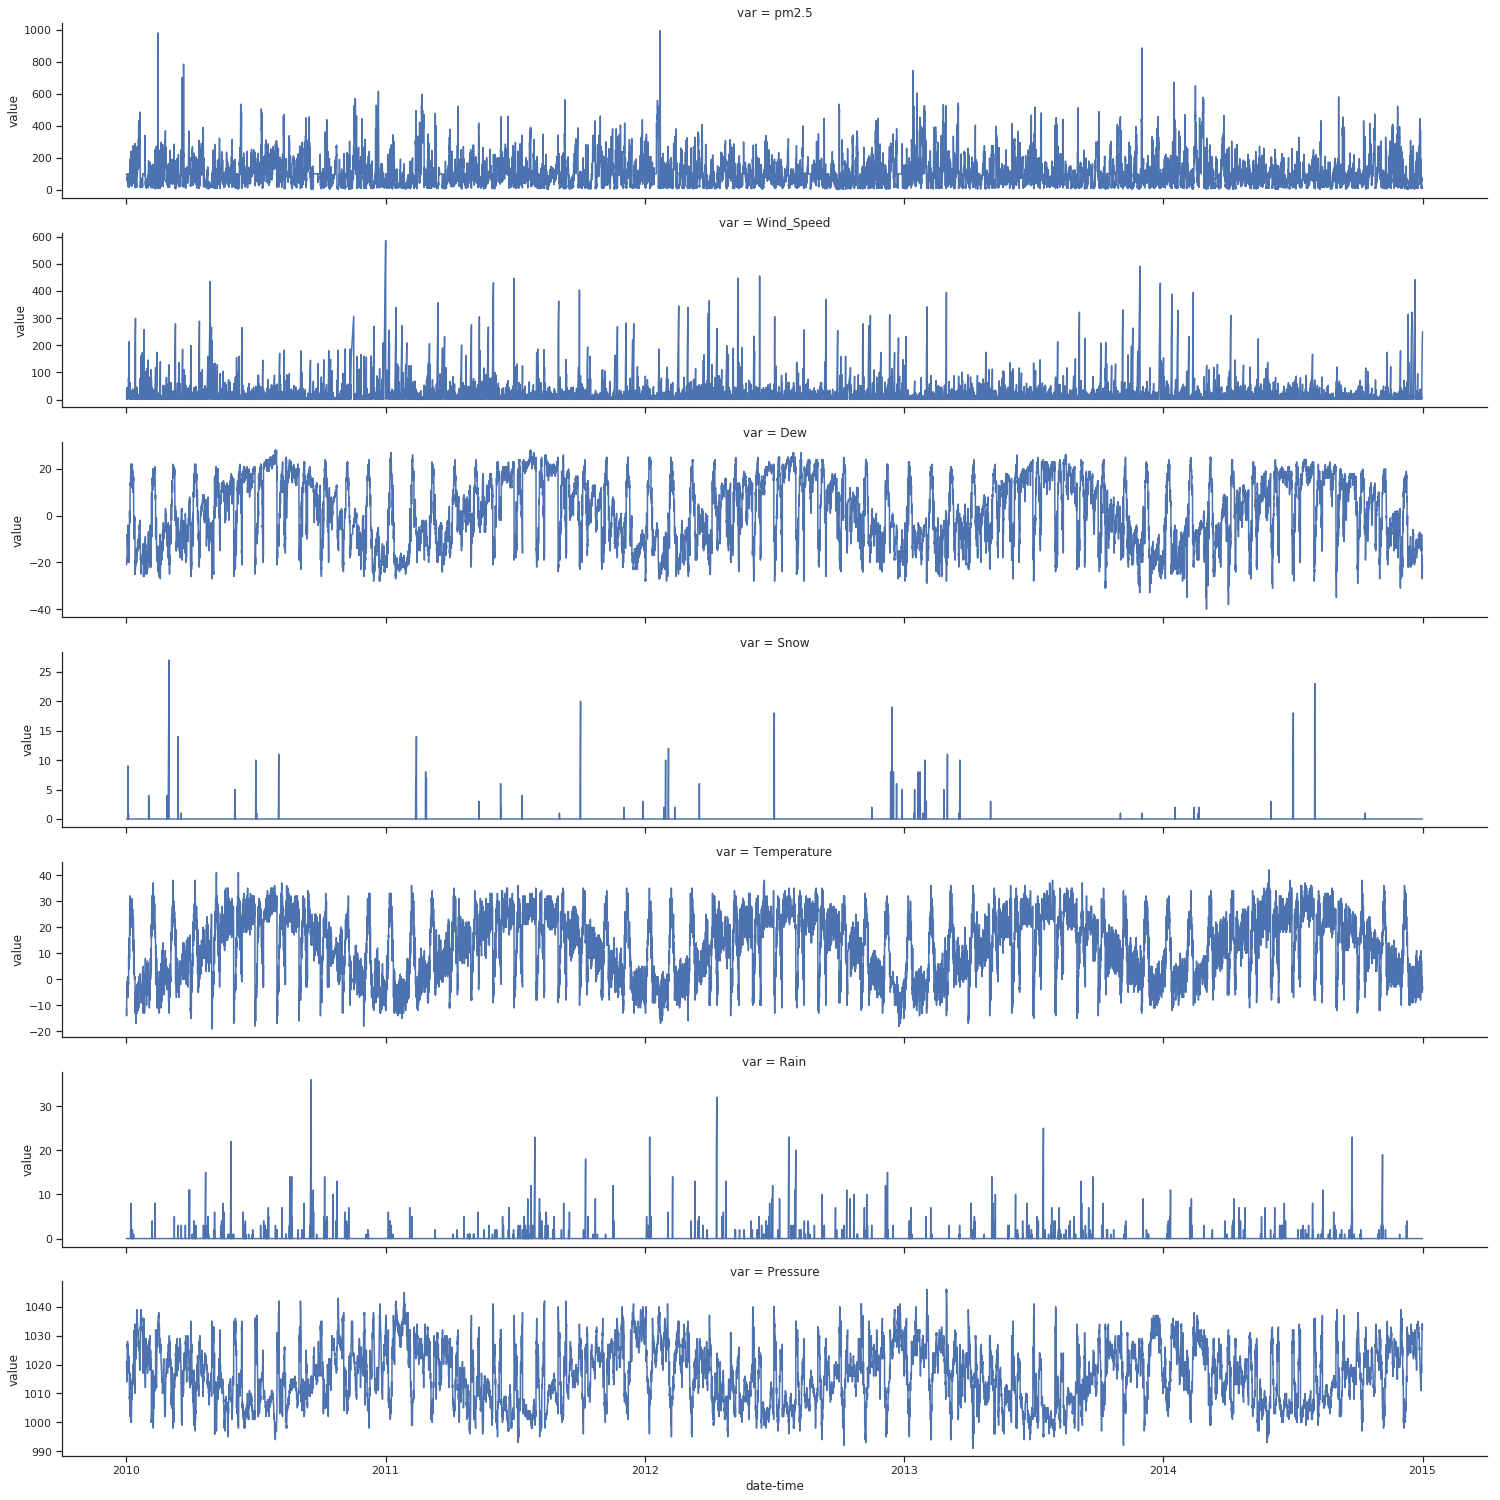

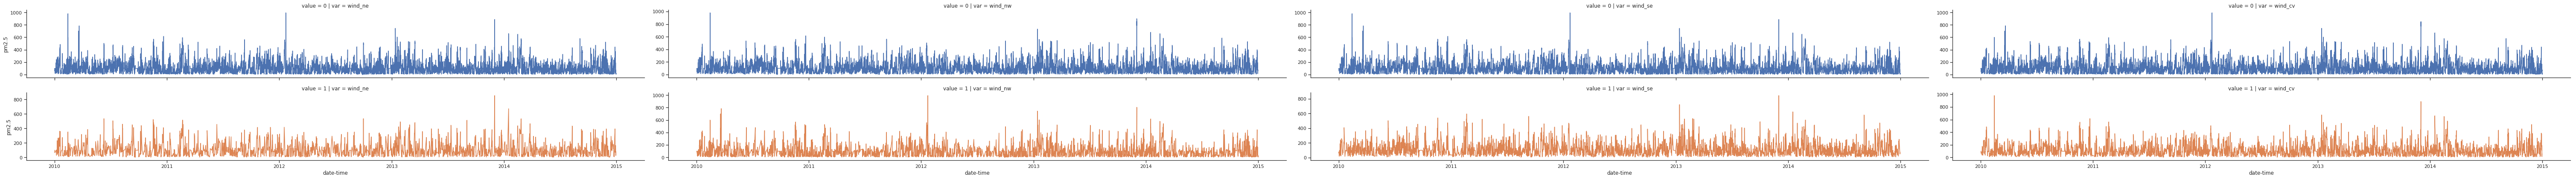

In [24]:
# write your code here

pollution = pd.read_csv('pollution.csv')

# Dropping the first day as there is no pollution data
#pollution = pollution.drop(range(0,24))

# Converting into date and time class
pollution['date-time'] = pollution["day"].map(str) +'-' + pollution["month"].map(str) + '-' + pollution['year'].map(str) +' ' +pollution['hour'].map(str) + ':00:00'
pollution['date-time'] = pd.to_datetime(pollution['date-time'])

# Replace missing value with mean 

print('{} missing values BEFORE'.format(pollution.isnull().sum().sum()))



'''
MISSING VALUES: As there are gaps of more than one day without information, the desition of filling the missing
    missing values with the average value was made. Previou/Next or zero filling was considered some sort of 
    brute forze.
'''

pollution.fillna(pollution.mean(), inplace=True)
#pollution.fillna(method='bfill', limit=24, inplace=True)
#pollution.fillna(method='ffill', limit=24, inplace=True)
print('{} missing values AFTER'.format(pollution.isnull().sum().sum()))

# Scatter Plot:
sns.set(style="ticks")
g1 = sns.pairplot(pollution, x_vars=['Temperature','Dew',"Pressure",'Wind_Speed','Snow','Rain'],
            y_vars=["pm2.5"])

# Variables Visualisation over the five-year period:
df = pollution[['date-time', 'pm2.5', 'Temperature', 'Dew',"Pressure",'Wind_Speed','Snow','Rain']]

df = df.melt(id_vars=['date-time'], var_name='var', value_name='value')
df = df.sort_values(by='date-time')

g2 = sns.FacetGrid(df, col="var",sharey=False, col_wrap=1, aspect=7)
g2 = g2.map(plt.plot, 'date-time','value')

# Turning Wind Direction into dummy vars:


'''
Our way of dealing wiht the categoric attribute is to create a binary variable for each possibility:
'''

pollution[['wind_ne', 'wind_nw', 'wind_se', 'wind_cv']] = pd.get_dummies(pollution['Wind_Direction'])
w_direc = ['wind_ne', 'wind_nw', 'wind_se', 'wind_cv']
df = pollution[['date-time', 'pm2.5', 'wind_ne', 'wind_nw', 'wind_se', 'wind_cv']]
df = df.melt(id_vars=['date-time', 'pm2.5'], var_name='var', value_name='value')
df = df.sort_values(by='date-time')

g3 = sns.FacetGrid(df, col="var", row='value',hue='value',sharey=False, aspect=7)
g3 = g3.map(plt.plot, 'date-time','pm2.5')


'''
GRAPHS:
1) By the scatter plots one can see how all the variables affect the pollution level. For example, the highest
pollution levels are shown to be present when the Temperature and Dew are between [-20,0], while grater Preassure
have a bit higher pollution level. On the other hand, while when the wind speed is low and there's no snow nor rain
one can see any pollution level (low and high), when these three factors are present and get higher, the pollution
level gets contracted and limited to values close to zero.

2) By visualising each variable as a time series, one can notice that Pressure, Drew and Temperature are the ones 
that present a clear seasonality (ciclicar pattern). Snow, Rain and Pollution level have a less obvious but still notorious pattern,
where the highest points are present at times of low or high temperature levels, respectively.

3) For the case of the Wind Direction, there is no visible pattern on the pollution levels by differenciating
the presence/absence of each direction.
'''

g1,g2,g3



b) Frame the task as the supervised learning problem as predicting the pollution at the current hour given the pollution measurement and weather conditions at the previous hour. Using the first 4 years' data as the training set and the remaining 1 year's data as the test set. Prepare the training/test sets accordingly.

In [67]:
from sklearn import preprocessing

# write your code here
df = pollution[['date-time', 'pm2.5', 'Temperature', 'Dew',"Pressure",'Wind_Speed','Snow','Rain',
               'wind_ne', 'wind_nw', 'wind_se', 'wind_cv']]
df = df.sort_values(by='date-time')
'''
===========================
SUPERVISED LEARNING FRAMING
===========================
'''

'''
Now we need to build a dataframe that contains all of our 11 variables information of the previous houre (t-1)
to predict the current hour (t) pollution level. For this task, we build a fuction that arranges the previuous 
observation with the current ones, and then drops the variables (all other than pollution level) that we do not 
use.
'''
df_1 = df.drop('date-time', axis=1)
values = df_1.values

# ensure all data is float
values = values.astype('float32')
    
# normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
def turn_to_supervised(data, n_back):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for i in range(n_back, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    cols.append(df.shift(0))
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]

    
    # put it all together
    df_c = pd.concat(cols, axis=1)
    df_c.columns = names
    # drop rows with NaN values
    df_c.dropna(inplace=True)
    
    return df_c


df_r = turn_to_supervised(scaled,1)
df_r.drop(df_r.columns[list(range(scaled.shape[1]+1,2*scaled.shape[1], 1))], axis=1, inplace=True)
df_r.head()


'''
====================================
TRAINING, VALIDATION AND TESTING SET
====================================
'''

'''
We are selecting the first four years as our training set and the rest of the dataset (one year) as our testing set.
Is worth to say that as our data is a time series, the selection has to be in order (not random) given the sequence
dependence of our information.
'''

# split into train and test sets
values = df_r.values
n_train_hours = 4 * 365 * 24 
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:int(0.9*len(train)), :-1], train[:int(0.9*len(train)), -1]
valid_X, valid_y = train[int(0.9*len(train)):, :-1], train[int(0.9*len(train)):, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, test_X.shape, test_y.shape)



(31536, 1, 11) (31536,) (3504, 1, 11) (3504,) (8783, 1, 11) (8783,)


c) Train a Recurrent Neural Network (RNN) on the training set. You can split the training set further by using 10% of the data as the validation set and the remaining for training.

In [68]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout

# write your code here
from keras.layers import SimpleRNN

'''
===============
SIMPLE NETWORK
===============
'''

'''
A simple RNN is expected to present a poor performance (compared with LSTM) given its short term memory. As we need
to find a connection between the data and the final output for several timesteps before, the vanishing gradient problem
(given the many multiplications in the hidden layers of the network) will make diffictul for the network to learn. 
We selected mae as our accuracy metric as it is less sensitive to outliers.
'''

model = Sequential()
model.add(SimpleRNN(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mae', optimizer='adam',metrics=['mae'])
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(valid_X, valid_y), verbose=2, shuffle=False)


Train on 31536 samples, validate on 3504 samples
Epoch 1/50
 - 4s - loss: 0.0777 - mean_absolute_error: 0.0777 - val_loss: 0.0526 - val_mean_absolute_error: 0.0526
Epoch 2/50
 - 1s - loss: 0.0448 - mean_absolute_error: 0.0448 - val_loss: 0.0340 - val_mean_absolute_error: 0.0340
Epoch 3/50
 - 1s - loss: 0.0277 - mean_absolute_error: 0.0277 - val_loss: 0.0257 - val_mean_absolute_error: 0.0257
Epoch 4/50
 - 1s - loss: 0.0259 - mean_absolute_error: 0.0259 - val_loss: 0.0249 - val_mean_absolute_error: 0.0249
Epoch 5/50
 - 1s - loss: 0.0254 - mean_absolute_error: 0.0254 - val_loss: 0.0246 - val_mean_absolute_error: 0.0246
Epoch 6/50
 - 1s - loss: 0.0251 - mean_absolute_error: 0.0251 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244
Epoch 7/50
 - 1s - loss: 0.0250 - mean_absolute_error: 0.0250 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243
Epoch 8/50
 - 1s - loss: 0.0249 - mean_absolute_error: 0.0249 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242
Epoch 9/50
 - 1s - loss: 0.0249

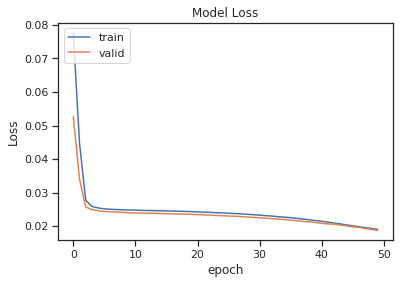

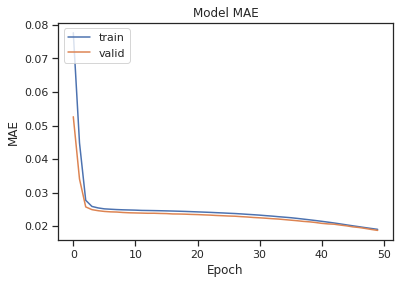

In [69]:
'''
The validation Loss and MAE is very close to the one of the training set, suggesting that the model es giving a
proper fitting.
'''

# summarize history for loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for mean absolute erros
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='valid')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()





d) Output the prediction results such as Root Mean Squared Errors (RMSE) on the test set. Remember that after the forecasts have been made, we need to invert the transforms to return the values back into the original scale. This is needed so that we can calculate error scores and plots that are comparable with other models. Plot the predicted values vs. the actual values.

In [70]:
from sklearn.metrics import mean_squared_error

# write your code here

'''
===========
EVALUATION
===========

By computing the RSME we get a value of 29.46, which is going to be meaningful once we have another model to
compare it to.
'''
# prediction
y_pred = model.predict(test_X)

test_X_new = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_ypred = np.concatenate((y_pred, test_X_new[:, 1:]), axis=1)
inv_ypred = scaler.inverse_transform(inv_ypred)
inv_ypred = inv_ypred[:,0]

# invert scaling for testin values
test_y_new = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_new, test_X_new[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_ypred))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 29.460


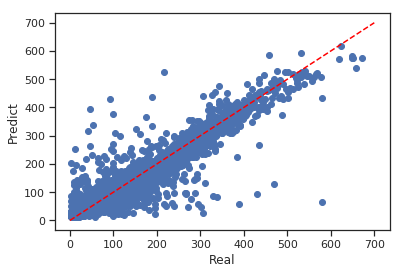

In [74]:
'''
By comparing the predicted vs. the real values, one can notice that more mistakes are made for the lower pollution
levels. In this part, there are some big over estimations, apparently less common than the under estimations. When the
real pollution levels increase, the model tends to under estimate. This is related to the fact the lower polution
levels are more frequent than the ones above 350.
'''

plt.plot(inv_y, inv_ypred, 'o')
plt.xlabel('Real')
plt.ylabel('Predict')
plt.plot([0,700], [0,700], color='red', linestyle='--')


e) Explore different network architectures (e.g., stacked LSTM layers) and various ways in tuning the model parameters to see if you can improve the model performance on the test set. 

In [75]:
# write your code here


'''
==================
NEW NETWORK (LSTM)
==================

For our improved model we are using two stacked LSTM layers which we expect to improve the estimation given the capability
of LSTM of bridging long time lags between inputs, making this model more proper given the sequence dependence of our
information.

'''

model = Sequential()
# arbitrarily picked the output dim to be 100
model.add(LSTM(100,input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# stacked LSTM layers
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mae', optimizer='adam',metrics=['mae'])
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72,
                    validation_data=(valid_X, valid_y), verbose=1, shuffle=False)


Train on 31536 samples, validate on 3504 samples
Epoch 1/50
31536/31536 [==============================] - 8s 258us/step - loss: 0.0891 - mean_absolute_error: 0.0891 - val_loss: 0.0484 - val_mean_absolute_error: 0.0484
Epoch 2/50
31536/31536 [==============================] - 4s 119us/step - loss: 0.0320 - mean_absolute_error: 0.0320 - val_loss: 0.0229 - val_mean_absolute_error: 0.0229
Epoch 3/50
31536/31536 [==============================] - 4s 114us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - val_loss: 0.0203 - val_mean_absolute_error: 0.0203
Epoch 4/50
31536/31536 [==============================] - 4s 116us/step - loss: 0.0197 - mean_absolute_error: 0.0197 - val_loss: 0.0187 - val_mean_absolute_error: 0.0187
Epoch 5/50
31536/31536 [==============================] - 4s 115us/step - loss: 0.0187 - mean_absolute_error: 0.0187 - val_loss: 0.0178 - val_mean_absolute_error: 0.0178
Epoch 6/50
31536/31536 [==============================] - 4s 118us/step - loss: 0.0181 - mean_absolut

Epoch 49/50
31536/31536 [==============================] - 4s 120us/step - loss: 0.0148 - mean_absolute_error: 0.0148 - val_loss: 0.0147 - val_mean_absolute_error: 0.0147
Epoch 50/50
31536/31536 [==============================] - 4s 119us/step - loss: 0.0148 - mean_absolute_error: 0.0148 - val_loss: 0.0146 - val_mean_absolute_error: 0.0146


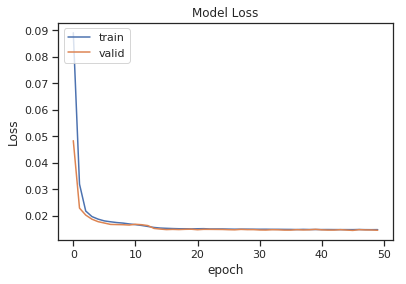

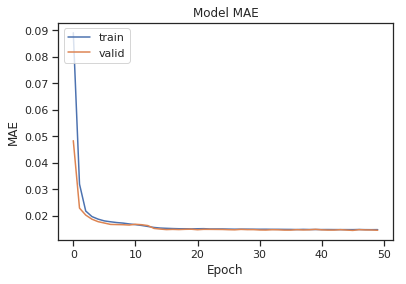

In [76]:
# summarize history for loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for mean absolute erros
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='valid')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


'''
The loss and MAE behavior of the improved model show an even better behavior, where the distance
between the two metrics (loss and MAE) of validation and training information is even smaller, suggesting that
the model es giving a better fit.
'''



Test RMSE: 27.135


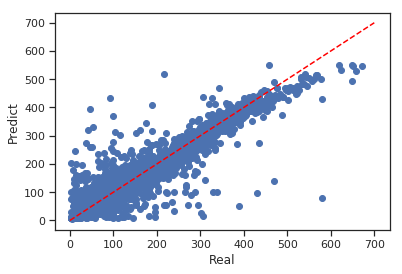

In [77]:

'''
===========
EVALUATION
===========


By computir the RMSE of the improved model and comparing it to the privious one, we can conclude that the second model
gives a better estimation of the pollution thanks to the capability of LSTM of bridging long time lags between inputs,
making this model more proper given the sequence dependence of our information.

By comparing the predicted vs. the real values, one can notice that the over fitting of the smaller pollution levels
decreased (compared to the previous model), and in general the mass of point seem to be closer to de diagonal. However,
the grater pollution levels present some underfitting. Overall, the perfomance of the LSTM model is better than a simple
RNN.
'''

# make a prediction
y_pred = model.predict(test_X)

test_X_new = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_ypred = np.concatenate((y_pred, test_X_new[:, 1:]), axis=1)
inv_ypred = scaler.inverse_transform(inv_ypred)
inv_ypred = inv_ypred[:,0]

# invert scaling for testing values
test_y_new = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_new, test_X_new[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_ypred))
print('Test RMSE: %.3f' % rmse)

plt.plot(inv_y, inv_ypred, 'o')
plt.xlabel('Real')
plt.ylabel('Predict')
plt.plot([0,700], [0,700], color='red', linestyle='--')

f) Explore alterative prediction setup by predicting the pollution for the next hour based on the weather conditions and pollution over the last 3 days.

In [78]:
# write your code here


'''
==============
 3 DAYS MODEL
==============


Now, we need to build a dataframe that contains all of our 11 explanatory variables of the previous three days
to predict the current hour (t) pollution level. For this task, we use the function we had already made, which arranges
N (24*3 in this case) previuous observation with the current ones, and then drops the variables (all other than pollution
level) that we do not use.
'''

df_r = turn_to_supervised(scaled,24*3)
df_r.drop(df_r.columns[list(range(24*3*scaled.shape[1]+1,scaled.shape[1]*(24*3+1), 1))], axis=1, inplace=True)

'''
========================
TRAINING AND TESTING SET
========================
'''

# split into train and test sets
values = df_r.values
n_train_hours = 4 * 365 * 24 
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:int(0.9*len(train)), :-1], train[:int(0.9*len(train)), -1]
valid_X, valid_y = train[int(0.9*len(train)):, :-1], train[int(0.9*len(train)):, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, test_X.shape, test_y.shape)



(31536, 1, 792) (31536,) (3504, 1, 792) (3504,) (8712, 1, 792) (8712,)


In [81]:
'''
===============
DESIGN NETWORK
===============
'''

model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# stacked LSTM layers
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mae', optimizer='adam',metrics=['mae'])
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(valid_X, valid_y), verbose=1, shuffle=False)


Train on 31536 samples, validate on 3504 samples
Epoch 1/50
31536/31536 [==============================] - 13s 402us/step - loss: 0.0620 - mean_absolute_error: 0.0620 - val_loss: 0.0536 - val_mean_absolute_error: 0.0536
Epoch 2/50
31536/31536 [==============================] - 8s 239us/step - loss: 0.0471 - mean_absolute_error: 0.0471 - val_loss: 0.0505 - val_mean_absolute_error: 0.0505
Epoch 3/50
31536/31536 [==============================] - 8s 241us/step - loss: 0.0399 - mean_absolute_error: 0.0399 - val_loss: 0.0477 - val_mean_absolute_error: 0.0477
Epoch 4/50
31536/31536 [==============================] - 8s 243us/step - loss: 0.0345 - mean_absolute_error: 0.0345 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 5/50
31536/31536 [==============================] - 8s 241us/step - loss: 0.0320 - mean_absolute_error: 0.0320 - val_loss: 0.0347 - val_mean_absolute_error: 0.0347
Epoch 6/50
31536/31536 [==============================] - 7s 237us/step - loss: 0.0302 - mean_absolu

Epoch 49/50
31536/31536 [==============================] - 8s 242us/step - loss: 0.0172 - mean_absolute_error: 0.0172 - val_loss: 0.0198 - val_mean_absolute_error: 0.0198
Epoch 50/50
31536/31536 [==============================] - 8s 247us/step - loss: 0.0177 - mean_absolute_error: 0.0177 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208


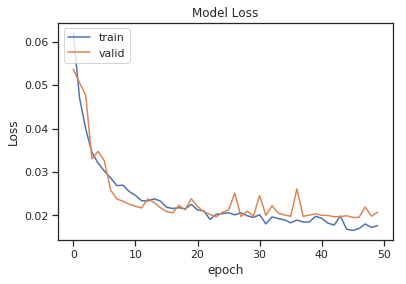

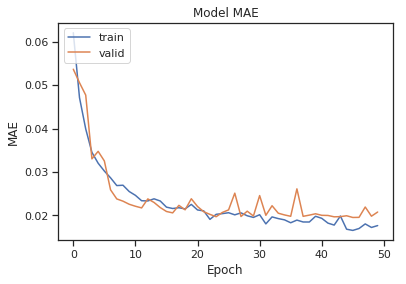

In [82]:
# summarize history for loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for mean absolute erros
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='valid')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

'''
The loss and MAE show a good decreasing behavior over the epochs. At the final stage, the two metrics of the 
training are a bit lower than on the validation informations, suggesting that our model is overfitting.
'''

Test RMSE: 33.687


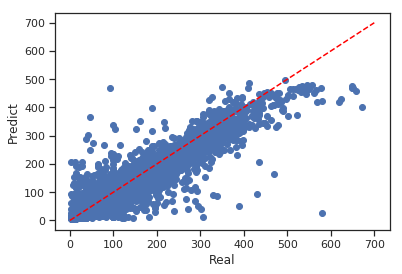

In [83]:

'''
===========
EVALUATION
===========


By computir the RMSE of this model, we obtained a value a bit larger that 33, whic means that for this information,
adding all the previous information is not helping the prediction. In other words, the curren pollution levels
is better explained by the recent observations (last hour).

By comparing the predicted vs. the real values of this las model, one can notice that the fitting behavior of the 
lower pollution levels is similar to the privous model (LSTM with only the previous hour information), where there is 
some overfitting and in general the mass of point seem to be closer to de diagonal. However, the grater pollutino levels
have an even higher level of underfitting than the previous model.
'''

# make a prediction
test_X, test_y = test[:, :-1], test[:, -1]
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
y_pred = model.predict(test_X)
test_X_new = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_ypred = np.concatenate((y_pred, test_X_new[:, 1:11]), axis=1)

inv_ypred = scaler.inverse_transform(inv_ypred)
inv_ypred = inv_ypred[:,0]

# invert scaling for actual
test_y_new = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_new, test_X_new[:, 1:11]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_ypred))
print('Test RMSE: %.3f' % rmse)

plt.plot(inv_y, inv_ypred, 'o')
plt.xlabel('Real')
plt.ylabel('Predict')
plt.plot([0,700], [0,700], color='red', linestyle='--')